In [1]:
import cv2
import torch
import einops
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms as pth_transforms

In [2]:
# checkpoint = torch.load('/home/surya/Downloads/fpn_dat_t_80k.pth')
# from collections import OrderedDict
# new_state_dict = OrderedDict()

# for k,v in checkpoint['state_dict'].items():
#     if('backbone' in k):
#         if(k.startswith("backbone.norms.")):
#             pass
#         else:
#             new_key = k.replace("backbone.", "")
#             new_state_dict[new_key] = v
# torch.save(new_state_dict, '/home/surya/Downloads/fpn_dat_t_backbone.pth')

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# load pretrained model
checkpoint = torch.load('/home/surya/Downloads/fpn_dat_t_backbone.pth')

from dat import DAT
model = DAT()
model.load_state_dict(checkpoint, strict=False)
model.eval();
model.to(device);

In [4]:
transform = pth_transforms.Compose([
        pth_transforms.ToTensor(),
        pth_transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])

def preprocess_image(image_path, reshape_size=(224, 224)):
    rgb_image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    rgb_image = cv2.resize(rgb_image, reshape_size, interpolation=cv2.INTER_LINEAR)
    img = transform(rgb_image).unsqueeze(0)
    return rgb_image, img

In [5]:
test_img_path = '/home/surya/Downloads/cat.jpg'
rgb_image, img = preprocess_image(test_img_path)
print(f"rgb_image shape = {rgb_image.shape}, img shape = {img.shape}")

rgb_image shape = (224, 224, 3), img shape = torch.Size([1, 3, 224, 224])


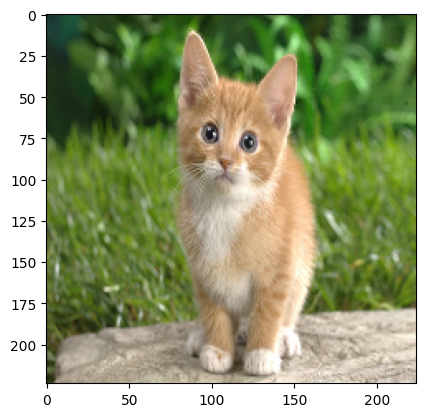

In [6]:
import matplotlib.pyplot as plt
plt.imshow(rgb_image)

In [7]:
output, deformed_pts = model(img)

torch.Size([2, 3136, 49])
torch.Size([1, 7, 7, 2])
-------------------
torch.Size([4, 784, 49])
torch.Size([2, 7, 7, 2])
torch.Size([4, 784, 49])
torch.Size([2, 7, 7, 2])
-------------------
torch.Size([8, 196, 49])
torch.Size([4, 7, 7, 2])
torch.Size([8, 196, 49])
torch.Size([4, 7, 7, 2])
torch.Size([8, 196, 49])
torch.Size([4, 7, 7, 2])
torch.Size([8, 196, 49])
torch.Size([4, 7, 7, 2])
torch.Size([8, 196, 49])
torch.Size([4, 7, 7, 2])
torch.Size([8, 196, 49])
torch.Size([4, 7, 7, 2])
torch.Size([8, 196, 49])
torch.Size([4, 7, 7, 2])
torch.Size([8, 196, 49])
torch.Size([4, 7, 7, 2])
torch.Size([8, 196, 49])
torch.Size([4, 7, 7, 2])
-------------------
torch.Size([16, 49, 49])
torch.Size([8, 7, 7, 2])
torch.Size([16, 49, 49])
torch.Size([8, 7, 7, 2])
-------------------


In [8]:
[x.shape for x in deformed_pts]

[(1, 1, 7, 7, 2),
 (1, 2, 7, 7, 2),
 (1, 2, 7, 7, 2),
 (1, 4, 7, 7, 2),
 (1, 4, 7, 7, 2),
 (1, 4, 7, 7, 2),
 (1, 4, 7, 7, 2),
 (1, 4, 7, 7, 2),
 (1, 4, 7, 7, 2),
 (1, 4, 7, 7, 2),
 (1, 4, 7, 7, 2),
 (1, 4, 7, 7, 2),
 (1, 8, 7, 7, 2),
 (1, 8, 7, 7, 2)]

In [9]:
attn_maps = []
for s in range(3,4):
    num_stage_attns = len(model.stages[s].attns)
    for a in range(1, num_stage_attns, 2):
        s_a_attn_map = model.stages[s].attns[a].attn
        attn_maps.append(s_a_attn_map.detach().cpu().numpy())

cumulative_attn_scores = [einops.rearrange(x, 'nh ps k -> (nh ps) k') for x in attn_maps]
cumulative_attn_scores = np.concatenate(cumulative_attn_scores, axis=0)
keypt_scores = np.sum(cumulative_attn_scores, axis=0)
print(keypt_scores.shape)

top_keys = np.argsort(keypt_scores)[::-1][:5]
print(top_keys)

(49,)
[ 1  0 24 48 47]


In [10]:
stacked_deformed_pts = np.concatenate([einops.rearrange(x[0], 'g h w p -> g (h w) p') for x in deformed_pts], axis = 0)
print(stacked_deformed_pts.shape)

(57, 49, 2)


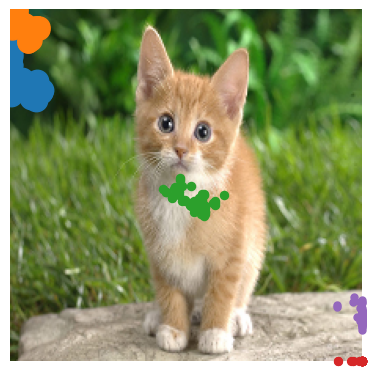

In [11]:
plt.imshow(rgb_image)
plt.axis('off')

for key_idx in top_keys:
    x_pixels = ((stacked_deformed_pts[:, key_idx, 0] + 1) * 112).astype(np.uint8)
    y_pixels = ((stacked_deformed_pts[:, key_idx, 1] + 1) * 112).astype(np.uint8)
    plt.scatter(x_pixels, y_pixels, s=keypt_scores[key_idx])
plt.grid(True)

In [22]:
import numpy as np
import matplotlib.patches as patches
import IPython.display as Disp
from ipywidgets import Button, Layout

class Visualize_Attention():
    def __init__(self, rgb_image, attention_map, patch_size =32, figsize=(5,5), cmap='jet'):
        self.rgb_image = rgb_image
        self.attention_map = attention_map
        self.ps = patch_size
        self.img_height, self.img_width, _ = self.rgb_image.shape
        
        self.fig = plt.figure(figsize=figsize)
        gs = self.fig.add_gridspec(nrows=6, ncols=6) # hspace =0, wspace=0
    
        # RGB image with gridlines
        self.rgb_axes = self.fig.add_subplot(gs[0:5, 1:5])
        self.rgb_axes.imshow(self.rgb_image)
        self.rgb_axes.set(xticks=[], yticks=[])
        for x in range(0, self.img_width, self.ps):
            self.rgb_axes.axvline(x, color='gray', linestyle='-', linewidth = 0.25)
        for y in range(0, self.img_height, self.ps):
            self.rgb_axes.axhline(y, color='gray', linestyle='-', linewidth = 0.25)        

        # attention maps subplot
        self.attn_head_axes = []
        for row in range(6):
            if row == 5:
                cols = np.arange(6).tolist()
            else:
                cols = [0,5]
            for col in cols:
                head_axes = self.fig.add_subplot(gs[row, col])
                im = head_axes.imshow(np.zeros((self.img_height, self.img_width)))
                head_axes.set(xticks=[], yticks=[])
                self.attn_head_axes.append(head_axes)                
                
        self.fig.tight_layout()
                
        # triggers
        self.trigger = self.fig.canvas.mpl_connect('button_press_event', self.onclick)
        # visualize_button = Button(description = "Visualize Attention Heads", layout = Layout(positioning='top'))
        # Disp.display(visualize_button)
        # visualize_button.on_click(self.plot_patch_attention)
    
    def onclick(self, event):
        if event.inaxes == self.rgb_axes:
            self.patch_x = int(event.xdata // self.ps)
            self.patch_y = int(event.ydata // self.ps)
            self.rgb_axes.patches.clear()
            rect = patches.Rectangle((self.patch_x * self.ps, self.patch_y * self.ps), 
                                      self.ps, self.ps, linewidth=1, ec='r', fc='none')
            self.rgb_axes.add_patch(rect)
    
    
    def plot_patch_attention(self, _):
        pass
#         # plot attention maps of all heads of corresponding patch
#         patch_attn = self.attention_map[:, self.patch_x * self.ps + self.patch_y]
#         patch_attn = patch_attn.reshape(-1, self.img_height // self.ps, self.img_width // self.ps)
# #         th_patch_attn = calculate_th_attention(patch_attn.reshape(6, -1), threshold=0.6)
# #         th_patch_attn = th_patch_attn.reshape(-1, self.img_height // self.ps, self.img_width // self.ps)
# #         th_patch_attn = cv2.blur(th_patch_attn,(10,10))
            
#         for hi, ax in enumerate(self.attn_head_axes):
#             ax.clear()
#             patch_attn_i = cv2.resize(patch_attn[hi], (self.img_width, self.img_height), cv2.INTER_LINEAR)
#             im = ax.imshow(patch_attn_i, cmap='jet')
#             ax.set(xticks=[], yticks=[])
#             self.fig.subplots_adjust(wspace=0, hspace=0)

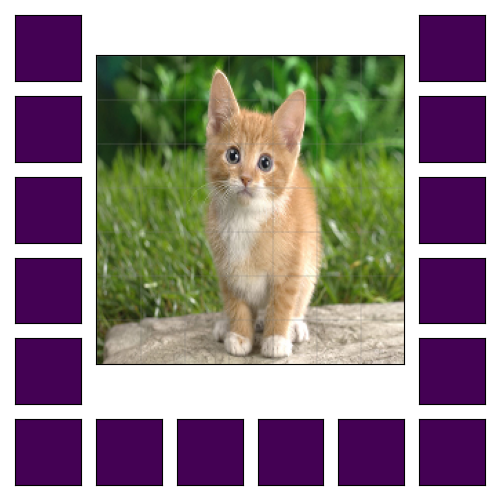

In [24]:
%matplotlib notebook
visualizer = Visualize_Attention(rgb_image, np.zeros((16, 49, 49)))